<a href="https://colab.research.google.com/github/yyoshiaki/2019SpringCamp_GP/blob/master/gpy_demo_inducing1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPyによるガウス過程回帰と補助変数法のデモ（1次元入力・1次元出力）


## まず GPy をインストールしつつ必要なパッケージを導入

In [0]:
# gpy を、google クラウド上でcolab環境を提供しているサーバーにインストールする。
# インストールには20秒ほどかかる

!pip install gpy
import GPy

# numpy と matplotlib は colab 環境にインストール済みなので import すればよい

import numpy as np
import matplotlib.pyplot as plt


    100% |████████████████████████████████| 880kB 826kB/s 
    100% |████████████████████████████████| 71kB 21.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/97/82/1d/32a361e1ff2b4d9129a60343831dd99cdc74440e2db1c55264
  Stored in directory: /root/.cache/pip/wheels/a9/fc/74/3bbd263c43ed98d67343df24cebf0a0ee34afee40d769fda9c
Successfully built gpy paramz


# GPy によるガウス過程のモデリング

参考：

GPy.models.gp_regression module を使用

https://gpy.readthedocs.io/en/deploy/GPy.models.html#module-GPy.models.gp_regression

GPy.kern.RBF を使用

https://gpy.readthedocs.io/en/deploy/GPy.kern.src.html#module-GPy.kern.src.rbf



In [0]:
def make_data():
    # 入出力データ点を作る関数
    N_in = 50
    x = np.concatenate( (
      np.linspace(-10,-5,N_in/4),
      np.linspace(-2,0,N_in/4),
      np.linspace(5,10,N_in/2) ) )
    y = np.sin(x/3)
    y = y + 0.1*np.random.normal(size=y.shape)
    x = x[:,None]
    y = y[:,None]
    return x,y

def fill_plot(x,y,v,c1,c2):
    # 確率過程の予測分布の平均と分散をプロットする関数
    f_upper, f_lower = y + 2*np.sqrt(v), y - 2.*np.sqrt(v)
    plt.fill_between(x[:,0], f_lower[:,0], f_upper[:,0], color=c1, alpha=.1)
    plt.plot(x[:], y[:],c2)


def visualize000(x,y,v,xs,ys):
    # 可視化作図関数
    fill_plot(x,y,v,'blue','b-')

    plt.plot(xs, ys, 'bo')
    plt.xlim((-15.0,15.0))
    plt.ylim((-3.0,3.0))
    plt.xlabel('x')
    plt.ylabel('y, f(x)')


Text(0.5, 1.0, 'With optimized hyper-parameters')

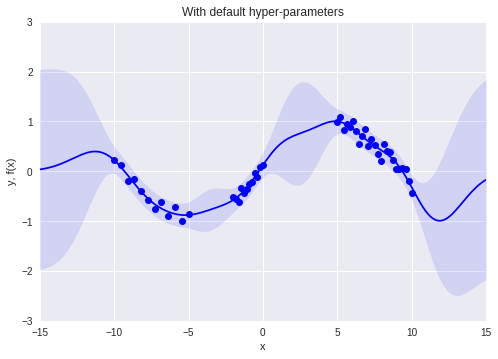

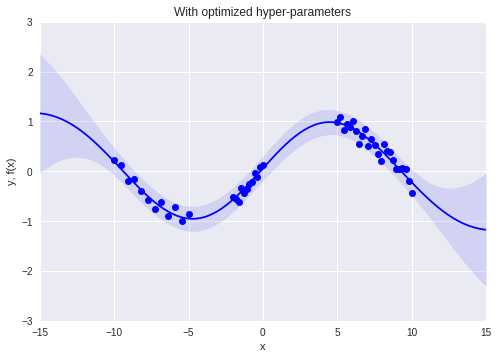

In [0]:
# GPy によるガウス過程モデリングのデモ
# 入出力データ点を作る
(xs, ys) = make_data()

# カーネル関数の定義 
# 【実習】　kernel の定義や、ハイパーパラメタ設定をいろいろ変えて実行してみましょう。

kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=2.) 
#kernel = GPy.kern.sde_Matern32(input_dim=1, lengthscale=2.) 
#kernel = GPy.kern.RBF(1) + GPy.kern.Bias(1) + GPy.kern.Linear(1)
#kernel = GPy.kern.Bias(1) + GPy.kern.Linear(1)

# ガウス過程回帰モデルの定義
model = GPy.models.GPRegression(xs,ys, kernel=kernel, noise_var = 0.01) 

# 予測結果描画用の入力点集合を用意
x = np.linspace(-15,15,200)
x = x[:,None]

# 予測分布の平均と分散を計算
[y,v] = model.predict(x)
plt.figure()
visualize000(x,y,v,xs,ys)
plt.title("With default hyper-parameters")


# ガウス過程回帰モデルのハイパーパラメタ最適化
model.optimize()

# 予測分布の平均と分散を計算
[y,v] = model.predict(x)

plt.figure()
visualize000(x,y,v,xs,ys)
plt.title("With optimized hyper-parameters")


## 補助変数法デモで使う関数の定義


In [0]:
def make_fig(fname, x, xs, ys, m1, m2):
    # 作図
    # fname : ファイル名
    # x : 予測用入力座標
    # xs, ys : 入出力データ点セット
    # m1 : 1つ目のモデル
    # m2 : 2つ目のモデル
    # m3 : 3つ目のモデル
    
    plt.cla()

    [y,v] = m1.predict(x)
    fill_plot(x,y,v,'blue','b-')

    [y,v] = m2.predict(x)
    fill_plot(x,y,v,'red','r-')

    plt.plot(xs, ys, 'bo')
    plt.xlim((-15.0,15.0))
    plt.ylim((-3.0,3.0))
    plt.xlabel('x, z')
    plt.ylabel('y, f(x)')
    M = z.shape[0] # 補助点の個数
    plt.title('M={}'.format(M))
    #  plt.savefig(fname)

   

## 補助変数法デモの本体

補助点の個数 $M$ を揃えて、補助変数法（左）と部分データ法（右）の結果を比較する。
青色は全データを用いたガウス過程回帰の結果、
赤色は補助変数法もしくは部分データ法の結果である。
実線は予測分布の平均であり、その上下の影は標準偏差である。
学習用の入出力データ点 $(x_i,y_i), i=1,\ldots,N_{\rm in},N_{\rm in} =50$ を青色マーカーで表示した。学習用データの中から無作為に$M$点を選んで補助点セット $Z=\{z_1,\ldots,z_M\}$とし、赤色マーカーで表示する。
試験入力点を $-15<x<15 $ から選んで表示する。


### 部分データ法と補助変数法の比較
共通点
- 計算コスト $O(M^3)$
- 補助点セット周辺では十分な精度

補助変数法のメリット：
-  補助点セット $Z$ をどこにでも置くことができる
- 補助点セットから離れた入力点においても、平均・標準偏差の近似精度が高い

=====Starting DEMO3======


<Figure size 720x432 with 0 Axes>

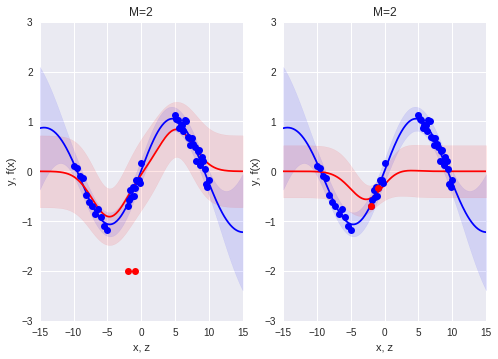

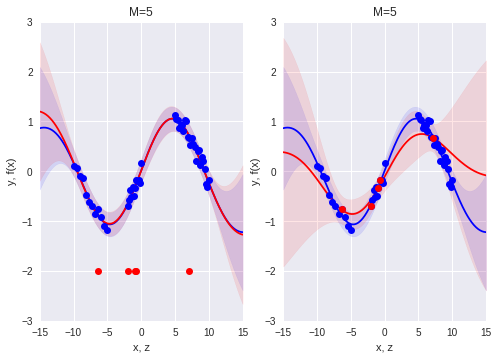

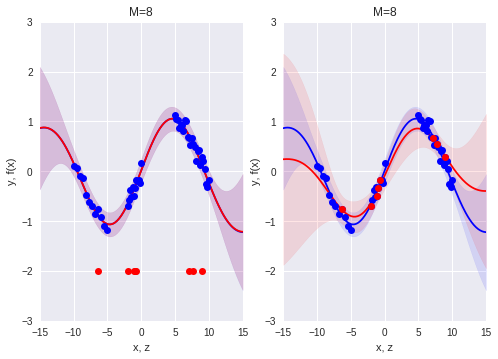

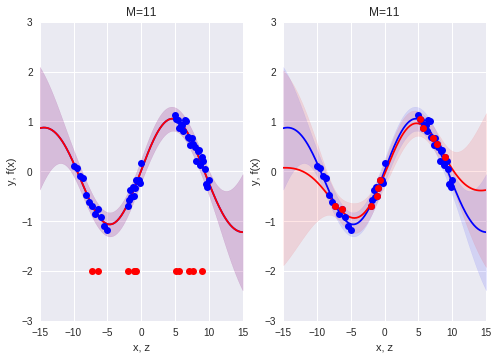

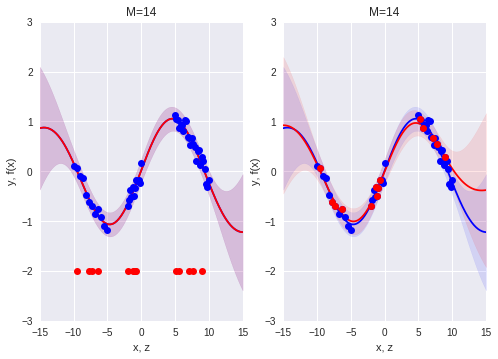

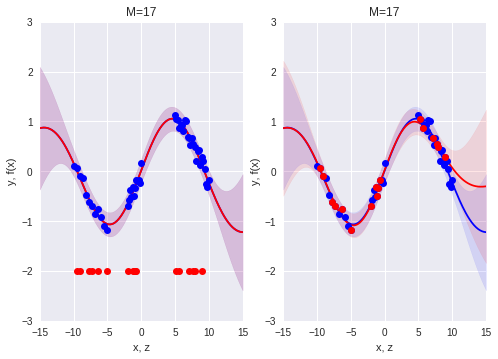

In [0]:
print('=====Starting DEMO3======')
fig = plt.figure(figsize=(10, 6))
(xs, ys) = make_data()

# カーネル関数の定義
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=2.)

# ガウス過程回帰モデルの定義
model = GPy.models.GPRegression(xs,ys, kernel=kernel, noise_var = 0.01)

# ガウス過程回帰モデルのハイパーパラメタ最適化
model.optimize()

# 予測結果描画用の入力点集合を用意
x_sim = np.linspace(-15,15,200)
x_sim = x_sim[:,None]

# カーネル関数の定義
# （最適化過程で書き換わってしまうため補助変数法のために別途作っておく必要がある）
kernel_sp = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=2.)
idx_z = np.random.permutation(xs.shape[0])
# 補助点の個数 k = 2:20 ごとに補助点法実験を行う
for k in range(2,20,3):
    # 補助入力点セットを定義
    ## ■ 注目 ■ ###
    z = xs[idx_z[0:k]]
    
    # 補助変数法にもとづくGP回帰モデルの定義
    ## ■ 注目 ■ ###
    model_sp = GPy.models.SparseGPRegression(xs,ys,kernel=kernel_sp,Z=z)
    # ハイパーパラメタの最適化
    model_sp.optimize()
    xsp = xs[idx_z[0:k]]
    ysp = ys[idx_z[0:k]]
    model_pp = GPy.models.GPRegression(xsp,ysp,kernel=kernel_sp,noise_var=0.01)

    
    # 出力ファイル名（←ここでは使わない）の定義
    fname = 'inducing003_{}.png'.format(k)
    # 作図
    fig = plt.figure()
    # 左側パネルは補助変数法
    ax = fig.add_subplot(1,2,1)
    make_fig(fname,x_sim,xs,ys,model,model_sp)
    plt.plot(z,z*0-2,'ro')
    # 右側パネルは部分データ法  
    ax = fig.add_subplot(1,2,2)
    make_fig(fname,x_sim,xs,ys,model,model_pp)
    plt.plot(xsp,ysp,'ro')



# 以下はデバッグ用のコード（無保証）（上も無保証ですが。。。）

=====Starting DEMO3======


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning:invalid value encountered in sqrt


<Figure size 720x432 with 0 Axes>

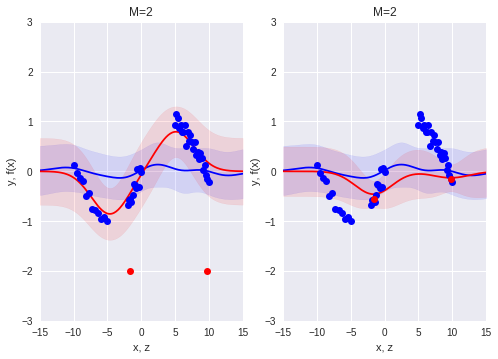

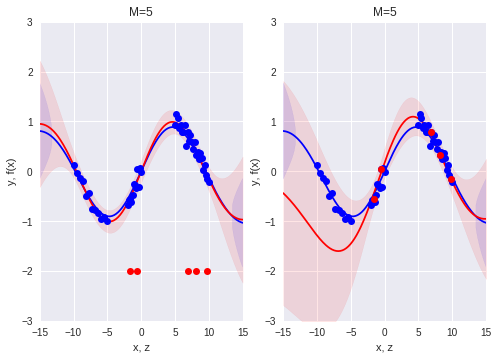

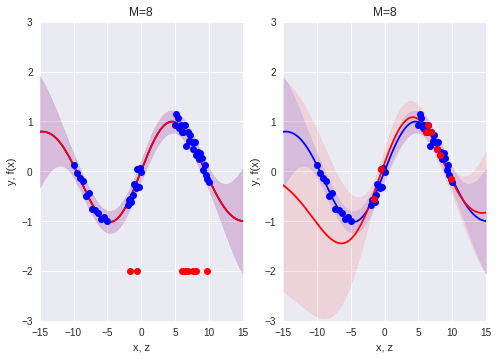

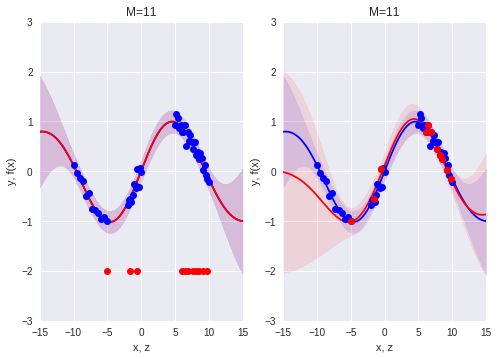

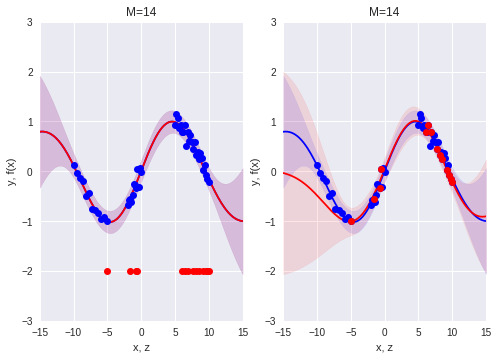

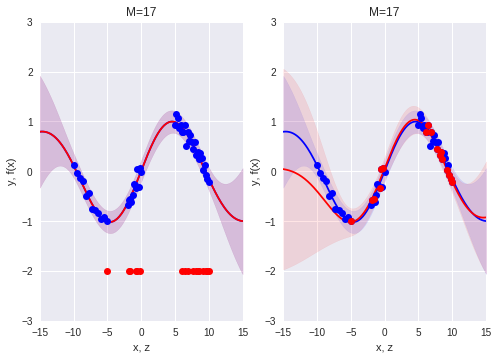

In [0]:
import copy

print('=====Starting DEMO3-2 ======')
fig = plt.figure(figsize=(10, 6))
(xs, ys) = make_data()

# カーネル関数の定義
# 【実習】 カーネル関数や、そのパラメタを変更しながら結果の違いを見てみましょう
ker = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=2.)
#ker = GPy.kern.sde_Matern32(input_dim=1, lengthscale=2.) 
# ker = GPy.kern.RBF(1) + GPy.kern.Bias(1) + GPy.kern.Linear(1)
#ker = GPy.kern.Bias(1) + GPy.kern.Linear(1)

# カーネル関数のコピー
# （最適化過程で書き換わってしまうため補助変数法のために別途作っておく必要がある）
ker_sp = copy.copy(ker)
ker_org = copy.copy(ker)
# ガウス過程回帰モデルの定義
model_original = GPy.models.GPRegression(xs,ys, kernel=ker_org, noise_var = 0.01)

# ガウス過程回帰モデルのハイパーパラメタ最適化
model_original.optimize()


# 予測結果描画用の入力点集合を用意
x_sim = np.linspace(-15,15,200)
x_sim = x_sim[:,None]

idx_z = np.random.permutation(xs.shape[0])
# 補助点の個数 k = 2:20 ごとに補助点法実験を行う
for k in range(2,20,3):
    # 補助入力点セットを定義
    ## ■ 注目 ■ ###
    z = xs[idx_z[0:k]]
    
    # 補助変数法にもとづくGP回帰モデルの定義
    ## ■ 注目 ■ ###
    model_sp = GPy.models.SparseGPRegression(xs,ys,kernel=ker_sp,Z=z)

    # ハイパーパラメタの最適化
    # 【実習】 以下をコメントアウトすることで、最適化しない場合の結果も見てみましょう
    model_sp.optimize()
    
    xsp = xs[idx_z[0:k]]
    ysp = ys[idx_z[0:k]]
    model_pp = GPy.models.GPRegression(xsp,ysp,kernel=ker_org,noise_var=0.01)

    
    # 出力ファイル名（←ここでは使わない）の定義
    fname = 'inducing003_{}.png'.format(k)
    # 作図
    fig = plt.figure()
    # 左側パネルは補助変数法
    ax = fig.add_subplot(1,2,1)
    make_fig(fname,x_sim,xs,ys,model_original,model_sp)
    plt.plot(z,z*0-2,'ro')
    # 右側パネルは部分データ法  
    ax = fig.add_subplot(1,2,2)
    make_fig(fname,x_sim,xs,ys,model_original,model_pp)
    plt.plot(xsp,ysp,'ro')



{'dataplot': [<matplotlib.collections.PathCollection at 0x7f7543200e80>],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f7542e00cf8>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f7542e00b38>]],
 'inducing': <matplotlib.collections.PathCollection at 0x7f7542e00828>}

 /usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


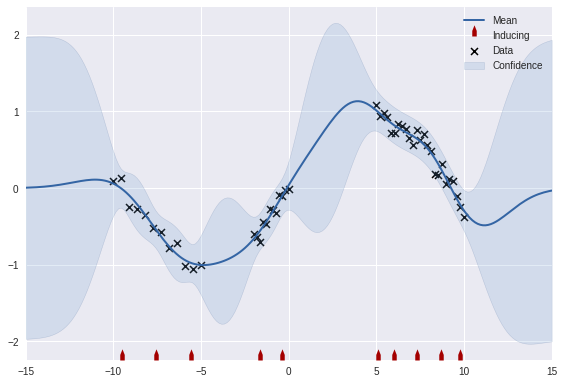

In [0]:
model_sp.plot()


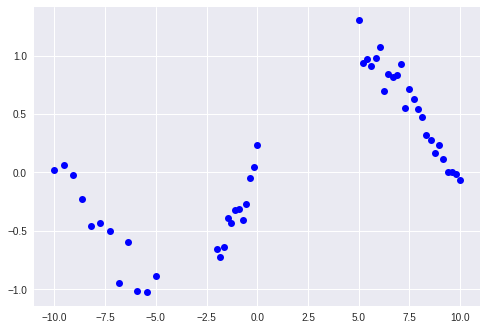

In [0]:
plt.plot(xs.flatten(), ys.flatten(),'bo')